In [2]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


In [3]:
def W_init(shape, name=None):
    values = rng.normal(loc=0, scale=1e-2,size=shape)
    return K.variable(values, name=name)
def b_init(shape, name=None):
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def load_best_acc(best_acc_str):
    with open('accuracies.txt') as f:
        content = f.readlines()
    best_acc = 0
    for line in content:
        if line.find(best_acc_str) >= 0:
            cont = line.split(' ')
            best_acc = int(cont[1])
    return best_acc

def save_best_acc(best_acc_str, best_acc):
    with open('accuracies.txt', 'r') as f :
        content = f.readlines()

    exists = False
    for i, s in enumerate(content):
        if content[i].find(best_acc_str) >= 0:
            content[i] = best_acc_str + ': ' + str(best_acc)
            exists = True

    if not exists:
        content.append(best_acc_str + ': ' + str(best_acc) + '\n')

    with open('accuracies.txt', 'w') as f:
        f.writelines(content)
    print(content)

In [3]:
input_shape=(105,105,1)
left_input = Input(input_shape)
right_input = Input(input_shape)

model = Sequential()
model.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                   kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128,(7,7),activation='relu',
                   kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(MaxPooling2D())
model.add(Dropout(0.2))
model.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
model.add(Flatten())
model.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))

encoded_l = model(left_input)
encoded_r = model(right_input)

L1_dist = lambda x: K.abs(x[0]-x[1])
both = merge([encoded_l,encoded_r], mode = L1_dist, output_shape = lambda x: x[0])
prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(both)
siamese_net = Model(input=[left_input,right_input],output=prediction)

optimizer = Adam(0.00006)
siamese_net.compile(loss='binary_crossentropy',optimizer=optimizer)

siamese_net.count_params()


/home/kbenda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/kbenda/anaconda2/lib/python2.7/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/kbenda/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`


38951745

In [4]:
class Siamese_Loader:
    def __init__(self,path):
        self.data = {}
        self.classes = {}
        with open(os.path.join(path,"train.pickle"), "rb") as f:
            (X,c) = pickle.load(f)
            self.data["train"] = X
            self.classes["train"] = c
            print(c)
        with open(os.path.join(path,"val.pickle"), "rb") as f:
            (X,c) = pickle.load(f)
            self.data["val"] = X
            self.classes["val"] = c
        self.n_classes,self.n_examples,self.w,self.h = self.data['train'].shape
#         n_classes: ennyi betu van a tanulo adatban (964)
#         n_examples: egy betuhoz 20 minta tartozik
#         w: a kepek szelessege (105)
#         h: a kepek magassaga (105)
        self.n_val,self.n_ex,_,_ = self.data['val'].shape
    
    '''Oszlopvektorokat alakit ki a kepekbol
    - a parok masodik fele megegyezo osztalybol az elso fele kulonbozo osztalybol szarmazik
    '''
    def get_batch(self,n,s='train'):
        X=self.data[s]
        classes=rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n,self.h,self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            class_ = classes[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = X[class_,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            class_2 = class_ if i >= n//2 else (class_ + rng.randint(1,self.n_classes)) % self.n_classes 
            pairs[1][i,:,:,:] = X[class_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets
    
    def do_oneshot_task(self, N,s='val', language=None):
        X = self.data[s]
        n_classes,n_examples = X.shape[0],X.shape[1]
        if language is None:
            classes = rng.choice(range(n_classes),size=(N,),replace=False)
            '''Nem biztos, hogy kell de szerintem igy a jo'''
            #             start_idx,end_idx = self.classes[s]
#             start_idx = 0
#             end_idx = self.classes[n].shape[0]
            indicies = rng.randint(0,self.n_examples,size=(N,))
        else:
            start_idx,end_idx = self.classes[s][language]
            try:
                classes = rng.choice(range(start_idx,end_idx),size=(N,),replace=False)
            except ValueError:
                    print("This language doesn't have enough characters for that one-shot task")
            indicies = rng.randint(0,self.n_examples,size=(N,))
        true_class = classes[0]
        ex1,ex2 = rng.choice(n_examples,size=(2,),replace=False)
#         A teszt kepet lemasoljuk sokszor, hogy a siamese halo egyik agara mindig ezt tegyuk 
        test_image = np.asarray([X[true_class,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = X[classes,indicies,:,:]
        support_set[0,:,:] = X[true_class,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        targets = np.zeros((N,))
        targets[0] = 1
        targets,test_image,support_set=shuffle(targets,test_image,support_set)
        pairs = [test_image,support_set]
        return pairs, targets
    
    '''Az N azt mondja meg, hogy egy kepet hany masikkal vizsgalunk meg'''
    '''A k azt mondja meg, hogy hanyszor teszteljuk a halot "hany one shot feladatot vegezzunk el"'''
    def test_oneshot(self,model,N,k,s='val',verbose=0):
        n_correct = 0
        if verbose:
            print("Evaluating model on {} unique {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs,targets = self.do_oneshot_task(N,s,language=None)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100*n_correct / k)
        if verbose:
            print("Got an avarage of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct

loader = Siamese_Loader("")

{'Alphabet_of_the_Magi': [185, 204], 'Cyrillic': [440, 472], 'Gujarati': [599, 646], 'Japanese_(katakana)': [83, 129], 'Japanese_(hiragana)': [647, 698], 'Sanskrit': [221, 262], 'Korean': [473, 512], 'Mkhedruli_(Georgian)': [318, 358], 'Ojibwe_(Canadian_Aboriginal_Syllabics)': [585, 598], 'Latin': [559, 584], 'Early_Aramaic': [699, 720], 'Grantha': [881, 923], 'Asomtavruli_(Georgian)': [924, 963], 'Futurama': [385, 410], 'Bengali': [513, 558], 'Inuktitut_(Canadian_Aboriginal_Syllabics)': [205, 220], 'Armenian': [799, 839], 'Anglo-Saxon_Futhorc': [411, 439], 'Tifinagh': [263, 317], 'Balinese': [775, 798], 'Braille': [359, 384], 'Greek': [857, 880], 'Tagalog': [840, 856], 'N_Ko': [130, 162], 'Blackfoot_(Canadian_Aboriginal_Syllabics)': [761, 774], 'Arcadian': [57, 82], 'Malay_(Jawi_-_Arabic)': [721, 760], 'Burmese_(Myanmar)': [0, 33], 'Hebrew': [163, 184], 'Syriac_(Estrangelo)': [34, 56]}


In [4]:
evaluate_every = 25
batch_size = 64
N_way = 50
n_val = 250

best_acc_str = 'BEST_ACC' + str(batch_size) + '_' + str(N_way) + '_' + str(n_val)
best_acc = load_best_acc(best_acc_str)
print("The best accuracy so far with this setup: {}".format(best_acc))
result_number = load_obj('result_number') + 1
results_detail = load_obj('results_detail')
results_detail[str(best_acc_str + '_' + str(result_number))] = {'%': [], 'iteration': [], 'loss': []}

The best accuracy so far with this setup: 47


In [16]:
print(best_acc_str)
print(results_detail)
print(result_number)

BEST_ACC64_50_250
{'BEST_ACC32_25_550_1': {'%': [17, 2, 8, 13, 17, 18, 21, 26, 25, 31, 30, 35, 30, 33, 29, 13, 16, 17, 19, 22, 20, 27, 19, 25, 30, 26, 30, 20, 28, 33, 29, 30, 29, 30, 28, 22, 31, 33, 28, 27, 38, 29, 33, 34, 36, 27, 30, 38, 33, 29, 32, 37, 36, 38, 28, 37, 36, 30, 41, 33, 42, 36, 37, 42, 42, 32, 35, 31, 41, 45, 36, 43, 44, 47, 43, 42, 44, 50, 46, 46, 46, 44, 46, 49, 45, 44, 51, 50, 52, 48, 48, 49, 49, 54, 52, 51, 52, 47, 53, 44, 53], 'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700, 1725, 1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250, 2275, 2300, 2325, 2350, 2375, 240

In [17]:
# siamese_net.load_weights("" + best_acc_str)

for i in range(0, 1500):
    (inputs,targets) = loader.get_batch(batch_size)
    loss = siamese_net.train_on_batch(inputs,targets)
    if i % evaluate_every == 0:
        val_acc = loader.test_oneshot(siamese_net,N_way,n_val,verbose=True)
        results_detail[best_acc_str + '_' + str(result_number)]['%'].append(val_acc)
        results_detail[best_acc_str + '_' + str(result_number)]['iteration'].append(i)
        results_detail[best_acc_str + '_' + str(result_number)]['loss'].append(loss)
        if val_acc >= best_acc:
            print("SAVING...")
            siamese_net.save('' + best_acc_str) 
            best_acc = val_acc
        print("Iteration {}, training loss: {:.2f},".format(i,loss))           

Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 19% 50 way one-shot learning accuracy
SAVING...
Iteration 0, training loss: 1.19,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 19% 50 way one-shot learning accuracy
SAVING...
Iteration 25, training loss: 1.29,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 14% 50 way one-shot learning accuracy
Iteration 50, training loss: 1.21,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 14% 50 way one-shot learning accuracy
Iteration 75, training loss: 1.15,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 20% 50 way one-shot learning accuracy
SAVING...
Iteration 100, training loss: 1.11,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 15% 50 way one-shot learning accuracy
Iteration 125, training loss: 1.00,
Evaluating model on 250 uni

Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 40% 50 way one-shot learning accuracy
Iteration 1275, training loss: 0.52,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 42% 50 way one-shot learning accuracy
Iteration 1300, training loss: 0.56,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 39% 50 way one-shot learning accuracy
Iteration 1325, training loss: 0.50,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 42% 50 way one-shot learning accuracy
Iteration 1350, training loss: 0.54,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 34% 50 way one-shot learning accuracy
Iteration 1375, training loss: 0.52,
Evaluating model on 250 unique 50 way one-shot learning tasks ...
Got an avarage of 47% 50 way one-shot learning accuracy
SAVING...
Iteration 1400, training loss: 0.42,
Evaluating model on 250 unique 50 wa

In [5]:
print(results_detail)

{'BEST_ACC32_25_50_3': {'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975], '%': [14, 10, 18, 22, 12, 32, 18, 26, 30, 40, 22, 30, 32, 22, 34, 34, 30, 32, 26, 32, 34, 28, 14, 6, 16, 16, 22, 30, 16, 10, 30, 22, 26, 28, 26, 30, 20, 44, 34, 32], 'loss': [8.3494492, 7.7579122, 7.2753434, 6.8041544, 6.3386841, 5.9444389, 5.5667057, 5.2193561, 4.8931885, 4.5966253, 4.3315191, 4.0797596, 3.8477678, 3.6422691, 3.449137, 3.2769439, 3.1137042, 2.9742994, 2.8298364, 2.7098086, 2.5802159, 2.4393063, 2.2464805, 2.1726422, 2.0031068, 2.1353836, 1.8619208, 1.8831431, 1.8172345, 1.6674182, 1.6726416, 1.5505798, 1.5202116, 1.5936472, 1.4165554, 1.4620322, 1.4579687, 1.26027, 1.4207015, 1.4425039]}, 'BEST_ACC32_25_550_1': {'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575,

In [19]:
print(best_acc)

47


### Run only if you want to SAVE the learning results

In [20]:
save_obj(results_detail, 'results_detail')
save_obj(result_number, 'result_number')
save_best_acc(best_acc_str, best_acc)

['BEST_ACC64_25_50: 72\n', 'BEST_ACC32_25_550: 54\n', 'BEST_ACC32_25_50: 44\n', 'BEST_ACC64_50_250: 47\n']


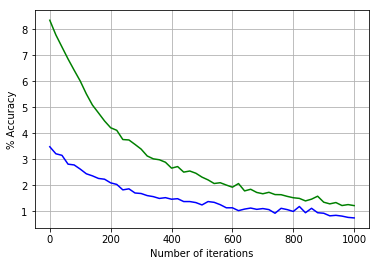

In [16]:
import matplotlib.pyplot as plt
import pylab

means = []
sum_ = 0
for i in range(0, len(results_detail['BEST_ACC64_50_250_4']['%'])):
    sum_ = sum_ + results_detail['BEST_ACC64_50_250_4']['%'][i]      
    means.append(sum_ / (i + 1))
    
plt.plot(results_detail['BEST_ACC64_25_50_0']['iteration'], 
         results_detail['BEST_ACC64_25_50_0']['loss'], 'b-'
         ,results_detail['BEST_ACC64_25_50_2']['iteration'],
#          means, 'r--'
         results_detail['BEST_ACC64_25_50_2']['loss'], 'g-'
        )
plt.grid(True)
plt.ylabel('% Accuracy')
plt.xlabel('Number of iterations')
# plt.text(500, 15, 'Dropout', color='green', fontsize='14')
plt.show()
# pylab.savefig("result1.png")

#### Can be deleted later:

In [16]:
plain_text = """
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 20% 25 way one-shot learning accuracy
saving...
Iteration 0, training loss: 3.48,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 22% 25 way one-shot learning accuracy
saving...
Iteration 20, training loss: 3.21,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 22% 25 way one-shot learning accuracy
saving...
Iteration 40, training loss: 3.15,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 32% 25 way one-shot learning accuracy
saving...
Iteration 60, training loss: 2.81,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
saving...
Iteration 80, training loss: 2.78,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 48% 25 way one-shot learning accuracy
saving...
Iteration 100, training loss: 2.62,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
Iteration 120, training loss: 2.44,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
saving...
Iteration 140, training loss: 2.36,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 38% 25 way one-shot learning accuracy
Iteration 160, training loss: 2.26,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 34% 25 way one-shot learning accuracy
Iteration 180, training loss: 2.23,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
Iteration 200, training loss: 2.09,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 50% 25 way one-shot learning accuracy
Iteration 220, training loss: 2.03,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 40% 25 way one-shot learning accuracy
Iteration 240, training loss: 1.82,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Iteration 260, training loss: 1.86,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Iteration 280, training loss: 1.70,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Iteration 300, training loss: 1.68,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
saving...
Iteration 320, training loss: 1.60,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Iteration 340, training loss: 1.56,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
saving...
Iteration 360, training loss: 1.49,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 56% 25 way one-shot learning accuracy
Iteration 380, training loss: 1.52,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
saving...
Iteration 400, training loss: 1.46,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
Iteration 420, training loss: 1.48,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
Iteration 440, training loss: 1.37,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
Iteration 460, training loss: 1.37,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 56% 25 way one-shot learning accuracy
Iteration 480, training loss: 1.33,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
Iteration 500, training loss: 1.24,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 48% 25 way one-shot learning accuracy
Iteration 520, training loss: 1.37,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 64% 25 way one-shot learning accuracy
saving...
Iteration 540, training loss: 1.34,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 60% 25 way one-shot learning accuracy
Iteration 560, training loss: 1.25,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
Iteration 580, training loss: 1.13,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 50% 25 way one-shot learning accuracy
Iteration 600, training loss: 1.13,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 46% 25 way one-shot learning accuracy
Iteration 620, training loss: 1.02,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
Iteration 640, training loss: 1.08,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 50% 25 way one-shot learning accuracy
Iteration 660, training loss: 1.12,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
Iteration 680, training loss: 1.07,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
Iteration 700, training loss: 1.10,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 56% 25 way one-shot learning accuracy
Iteration 720, training loss: 1.06,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 72% 25 way one-shot learning accuracy
saving...
Iteration 740, training loss: 0.92,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 56% 25 way one-shot learning accuracy
Iteration 760, training loss: 1.11,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
Iteration 780, training loss: 1.06,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
Iteration 800, training loss: 0.99,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
Iteration 820, training loss: 1.18,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
Iteration 840, training loss: 0.94,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 66% 25 way one-shot learning accuracy
Iteration 860, training loss: 1.11,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
Iteration 880, training loss: 0.94,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 70% 25 way one-shot learning accuracy
Iteration 900, training loss: 0.92,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 70% 25 way one-shot learning accuracy
Iteration 920, training loss: 0.82,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 62% 25 way one-shot learning accuracy
Iteration 940, training loss: 0.84,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 60% 25 way one-shot learning accuracy
Iteration 960, training loss: 0.81,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 64% 25 way one-shot learning accuracy
Iteration 980, training loss: 0.76,
Evaluating model on 50 unique 25 way one-shot learning tasks ...
Got an avarage of 58% 25 way one-shot learning accuracy
Iteration 1000, training loss: 0.74,
"""
plain_text = '''
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 17% 25 way one-shot learning accuracy
SAVING...
Iteration 0, training loss: 8.34,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 2% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 8% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 13% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 17% 25 way one-shot learning accuracy
SAVING...
Iteration 100, training loss: 6.30,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 18% 25 way one-shot learning accuracy
SAVING...
Iteration 125, training loss: 5.89,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 21% 25 way one-shot learning accuracy
SAVING...
Iteration 150, training loss: 5.48,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 26% 25 way one-shot learning accuracy
SAVING...
Iteration 175, training loss: 5.15,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 25% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 31% 25 way one-shot learning accuracy
SAVING...
Iteration 225, training loss: 4.55,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 35% 25 way one-shot learning accuracy
SAVING...
Iteration 275, training loss: 4.04,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 29% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 13% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 16% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 17% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 19% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 22% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 20% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 27% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 19% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 25% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 26% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 20% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 28% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 29% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 29% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 28% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 22% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 31% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 28% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 27% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 38% 25 way one-shot learning accuracy
SAVING...
Iteration 1000, training loss: 1.26,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 29% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 34% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 27% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 38% 25 way one-shot learning accuracy
SAVING...
Iteration 1175, training loss: 1.13,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 29% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 32% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 37% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 38% 25 way one-shot learning accuracy
SAVING...
Iteration 1325, training loss: 0.99,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 28% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 37% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 30% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 41% 25 way one-shot learning accuracy
SAVING...
Iteration 1450, training loss: 0.94,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 33% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
SAVING...
Iteration 1500, training loss: 0.89,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 37% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
SAVING...
Iteration 1575, training loss: 0.88,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
SAVING...
Iteration 1600, training loss: 0.86,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 32% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 35% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 31% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 41% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 45% 25 way one-shot learning accuracy
SAVING...
Iteration 1725, training loss: 0.81,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 36% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 43% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 47% 25 way one-shot learning accuracy
SAVING...
Iteration 1825, training loss: 0.79,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 43% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 42% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 50% 25 way one-shot learning accuracy
SAVING...
Iteration 1925, training loss: 0.76,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 46% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 46% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 46% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 46% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 49% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 45% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 51% 25 way one-shot learning accuracy
SAVING...
Iteration 2150, training loss: 0.68,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 50% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
SAVING...
Iteration 2200, training loss: 0.66,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 48% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 48% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 49% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 49% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 54% 25 way one-shot learning accuracy
SAVING...
Iteration 2325, training loss: 0.53,
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 51% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 52% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 47% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 53% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 44% 25 way one-shot learning accuracy
Evaluating model on 550 unique 25 way one-shot learning tasks ...
Got an avarage of 53% 25 way one-shot learning accuracy
'''

In [15]:
import re
substr = ['%','Iteration ','loss:']
indices = {}
indices[0] = [m.start() for m in re.finditer(substr[0], plain_text)]
indices[1] = [m.start() for m in re.finditer(substr[1], plain_text)]
indices[2] = [m.start() for m in re.finditer(substr[2], plain_text)]
result_part = {'%': [], 'iteration': [], 'loss': []}
for i in range(0,len(indices[0])):
    result_part['%'].append(int(plain_text[int(indices[0][i]-2):indices[0][i]]))
    if i == 0:
        result_part["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+11)]))
    elif i < 5:
        result_part["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+12)]))
    elif i < 50:
        result_part["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+13)]))
    else:
        result_part["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+14)]))
    result_part['loss'].append(float(plain_text[int(indices[2][i]+6):int(indices[2][i]+10)]))
result_part
results_detail[str(best_acc_str + '_' + str(result_number))] = result_part
# results_detail['BEST_ACC64_25_50_0'] = BEST_ACC64_25_50_results
print(results_detail)

<type 'list'>
<type 'dict'>
{'BEST_ACC32_25_550_2': {'iteration': [], '%': [], 'loss': []}, 'BEST_ACC64_25_50_0': {'iteration': [0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000], '%': [20, 22, 22, 32, 44, 48, 42, 52, 38, 34, 42, 50, 40, 44, 36, 44, 52, 44, 58, 56, 58, 52, 54, 52, 56, 52, 48, 64, 60, 58, 50, 46, 58, 50, 54, 42, 56, 72, 56, 54, 54, 58, 54, 66, 58, 70, 70, 62, 60, 64, 58], 'loss': [3.48, 3.21, 3.15, 2.81, 2.78, 2.62, 2.44, 2.36, 2.26, 2.23, 2.09, 2.03, 1.82, 1.86, 1.7, 1.68, 1.6, 1.56, 1.49, 1.52, 1.46, 1.48, 1.37, 1.37, 1.33, 1.24, 1.37, 1.34, 1.25, 1.13, 1.13, 1.02, 1.08, 1.12, 1.07, 1.1, 1.06, 0.92, 1.11, 1.06, 0.99, 1.18, 0.94, 1.11, 0.94, 0.92, 0.82, 0.84, 0.81, 0.76, 0.74]}}


In [23]:
substr = ['%','Iteration ','loss:']
indices = {}
indices[0] = [m.start() for m in re.finditer(substr[0], plain_text)]
# indices[1] = [m.start() for m in re.finditer(substr[1], plain_text)]
indices[2] = [m.start() for m in re.finditer(substr[2], plain_text)]
result_part = {'%': [], 'iteration': [], 'loss': []}
print(type(result_part['%']))
i25 = 0
j = 0
for i in range(0,len(indices[0])):
    result_part['%'].append(int(plain_text[int(indices[0][i]-2):indices[0][i]]))
    
    result_part['iteration'].append(i25)
    i25 += 25
#     if i == 0:
#         BEST_ACC64_25_50_results["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+11)]))
#     elif i < 5:
#         BEST_ACC64_25_50_results["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+12)]))
#     elif i < 50:
#         BEST_ACC64_25_50_results["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+13)]))
#     else:
#         BEST_ACC64_25_50_results["iteration"].append(int(plain_text[int(indices[1][i]+10):int(indices[1][i]+14)]))
    if i < len(indices[0]) - 1 and j < len(indices[2]):
        if indices[2][j] > indices[0][i] and indices[2][j] < indices[0][i+1]:
            result_part['loss'].append(float(plain_text[int(indices[2][j]+6):int(indices[2][j]+10)]))
            j += 1
        else:
            result_part['loss'].append(float(0))

results_detail[str(best_acc_str + '_' + str(result_number))] = result_part
# results_detail['BEST_ACC32_25_550_1'] = result_part
print(results_detail)

<type 'list'>
{'BEST_ACC32_25_550_1': {'iteration': [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000, 1025, 1050, 1075, 1100, 1125, 1150, 1175, 1200, 1225, 1250, 1275, 1300, 1325, 1350, 1375, 1400, 1425, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1675, 1700, 1725, 1750, 1775, 1800, 1825, 1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050, 2075, 2100, 2125, 2150, 2175, 2200, 2225, 2250, 2275, 2300, 2325, 2350, 2375, 2400, 2425, 2450, 2475, 2500], '%': [17, 2, 8, 13, 17, 18, 21, 26, 25, 31, 30, 35, 30, 33, 29, 13, 16, 17, 19, 22, 20, 27, 19, 25, 30, 26, 30, 20, 28, 33, 29, 30, 29, 30, 28, 22, 31, 33, 28, 27, 38, 29, 33, 34, 36, 27, 30, 38, 33, 29, 32, 37, 36, 38, 28, 37, 36, 30, 41, 33, 42, 36, 37, 42, 42, 32, 35, 31, 41, 45, 36, 43, 44, 47, 43, 42, 44, 50, 46, 46, 46, 44, 46, 49, 45, 44, 51, 50, 52, 48, 48, 49, 49, 54, 52, 5